In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

# text preprocessing
from nltk.tokenize import word_tokenize
import re

# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# preparing input to our model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# keras layers
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense

In [ ]:
# Number of labels: joy, sadness, fear, anger, surprise, neutral, disgust, shame, guilt
num_classes = 9

# Number of dimensions for word embedding
embed_num_dims = 300

# Max input length (max number of words)
max_seq_len = 500

class_names = ['joy', 'sadness', 'fear', 'anger', 'surprise', 'neutral', 'disgust', 'shame', 'guilt']

In [ ]:
data_train = pd.read_csv('/content/drive/MyDrive/NLP_PROJECT/Train.csv', encoding='utf-8')
data_test = pd.read_csv('/content/drive/MyDrive/NLP_PROJECT/Test.csv', encoding='utf-8')

X_train = data_train.Text
X_test = data_test.Text

y_train = data_train.Emotion
y_test = data_test.Emotion

data = pd.concat([data_train, data_test], ignore_index=True)

In [ ]:
print(data.Emotion.value_counts())
data.head(6)

Emotion
joy         12605
sadness      8364
fear         6914
anger        5851
surprise     4275
neutral      2254
disgust      2018
shame        1346
guilt        1052
Name: count, dtype: int64


,Text,Emotion
0,Such as ?,neutral
1,I felt angry when I saw on T.V the last slaugh...,anger
2,Home from a long fun day with my girls @ colle...,joy
3,Apparently everyone at work but me knew it was...,surprise
4,"“@RevRunWisdom: not afraid of tomorrow, for I ...",fear
5,"For Christmas, my parents go shopping together...",surprise


In [ ]:
def clean_text(data):

    # remove hashtags and @usernames
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)

    # tekenization using nltk
    data = word_tokenize(data)

    return data

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
texts = [' '.join(clean_text(text)) for text in data.Text]

texts_train = [' '.join(clean_text(text)) for text in X_train]
texts_test = [' '.join(clean_text(text)) for text in X_test]

In [ ]:
print(texts_train[92])

` In fact , `` said Helen , ` I 'm not feeling particularly glum about all this .


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

# vacab size is number of unique words + reserved 0 index for padding
vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 31019


In [ ]:
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

X_train_pad

array([[   0,    0,    0, ...,    0,  258,   36],
       [   0,    0,    0, ...,    9, 1076, 1927],
       [   0,    0,    0, ..., 5233,  400,   89],
       ...,
       [   0,    0,    0, ...,    9,    2, 2420],
       [   0,    0,    0, ...,    6,  546, 2018],
       [   0,    0,    0, ...,   98,  506,   14]], dtype=int32)

In [ ]:
encoding = {
    'joy': 0,
    'sadness': 1,
    'fear': 2,
    'anger': 3,
    'surprise': 4,
    'neutral': 5,
    'disgust': 6,
    'shame': 7,
    'guilt': 8
}

# Integer labels
y_train = [encoding[x] for x in data_train.Emotion]
y_test = [encoding[x] for x in data_test.Emotion]

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

In [ ]:
import urllib.request
import zipfile
import os

fname = '/content/drive/MyDrive/NLP_PROJECT/embeddings/wiki-news-300d-1M.vec'

if not os.path.isfile(fname):
    print('Downloading word vectors...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip',
                              'wiki-news-300d-1M.vec.zip')
    print('Unzipping...')
    with zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    print('done.')

    os.remove('wiki-news-300d-1M.vec.zip')

In [ ]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath, encoding='utf-8') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

In [ ]:
embedd_matrix = create_embedding_matrix(fname, index_of_words, embed_num_dims)
embedd_matrix.shape

(31020, 300)

In [ ]:
# Inspect unseen words
new_words = 0

for word in index_of_words:
    entry = embedd_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1

print('Words found in wiki vocab: ' + str(len(index_of_words) - new_words))
print('New words found: ' + str(new_words))

Words found in wiki vocab: 24585
New words found: 6434


In [ ]:
from tensorflow.keras.layers import Embedding

embedd_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length=max_seq_len,
                         weights=[embedd_matrix],
                         trainable=False)

In [ ]:
# Parameters
gru_output_size = 128
bidirectional = True

# Embedding Layer, LSTM or biLSTM, Dense, softmax
model = Sequential()
model.add(embedd_layer)

if bidirectional:
    model.add(Bidirectional(GRU(units=gru_output_size,
                              dropout=0.2,
                              recurrent_dropout=0.2)))
else:
     model.add(GRU(units=gru_output_size,
                dropout=0.2,
                recurrent_dropout=0.2))

model.add(Dense(num_classes, activation='softmax'))

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 300)          9306000   
                                                                 
 bidirectional (Bidirection  (None, 256)               330240    
 al)                                                             
                                                                 
 dense (Dense)               (None, 9)                 2313      
                                                                 
Total params: 9638553 (36.77 MB)
Trainable params: 332553 (1.27 MB)
Non-trainable params: 9306000 (35.50 MB)
_________________________________________________________________


In [ ]:
batch_size = 128
epochs = 15

hist = model.fit(X_train_pad, y_train,
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test))

Epoch 1/15
245/245 [==============================] - 695s 3s/step - loss: 1.6029 - accuracy: 0.4321 - val_loss: 1.3205 - val_accuracy: 0.5388
Epoch 2/15
245/245 [==============================] - 695s 3s/step - loss: 1.2424 - accuracy: 0.5696 - val_loss: 1.1852 - val_accuracy: 0.5830
Epoch 3/15
245/245 [==============================] - 692s 3s/step - loss: 1.1351 - accuracy: 0.6097 - val_loss: 1.1011 - val_accuracy: 0.6098
Epoch 4/15
245/245 [==============================] - 690s 3s/step - loss: 1.0767 - accuracy: 0.6281 - val_loss: 1.0847 - val_accuracy: 0.6211
Epoch 5/15
245/245 [==============================] - 697s 3s/step - loss: 1.0387 - accuracy: 0.6391 - val_loss: 1.0516 - val_accuracy: 0.6300
Epoch 6/15
245/245 [==============================] - 684s 3s/step - loss: 1.0060 - accuracy: 0.6513 - val_loss: 1.0386 - val_accuracy: 0.6360
Epoch 7/15
245/245 [==============================] - 687s 3s/step - loss: 0.9767 - accuracy: 0.6594 - val_loss: 1.0209 - val_accuracy: 0.6419

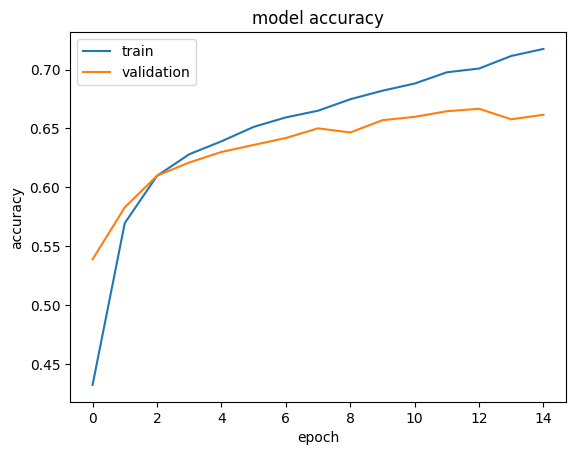

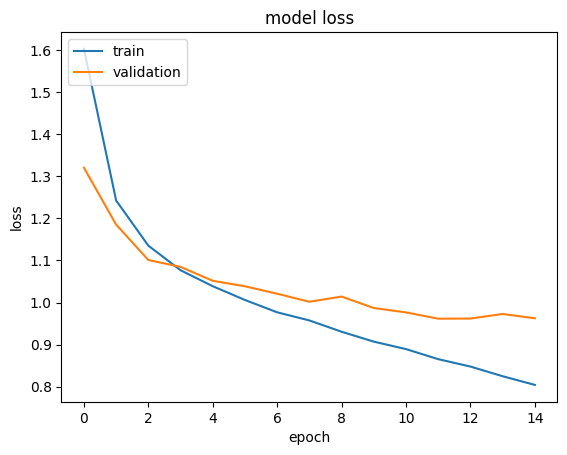

In [ ]:
#  "Accuracy"
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

419/419 [==============================] - 127s 303ms/step


In [ ]:
print("Accuracy: {:.2f}%".format(accuracy_score(data_test.Emotion, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))

Accuracy: 66.17%

F1 Score: 66.17


In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()

    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)

    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


F1 Score: 66.17


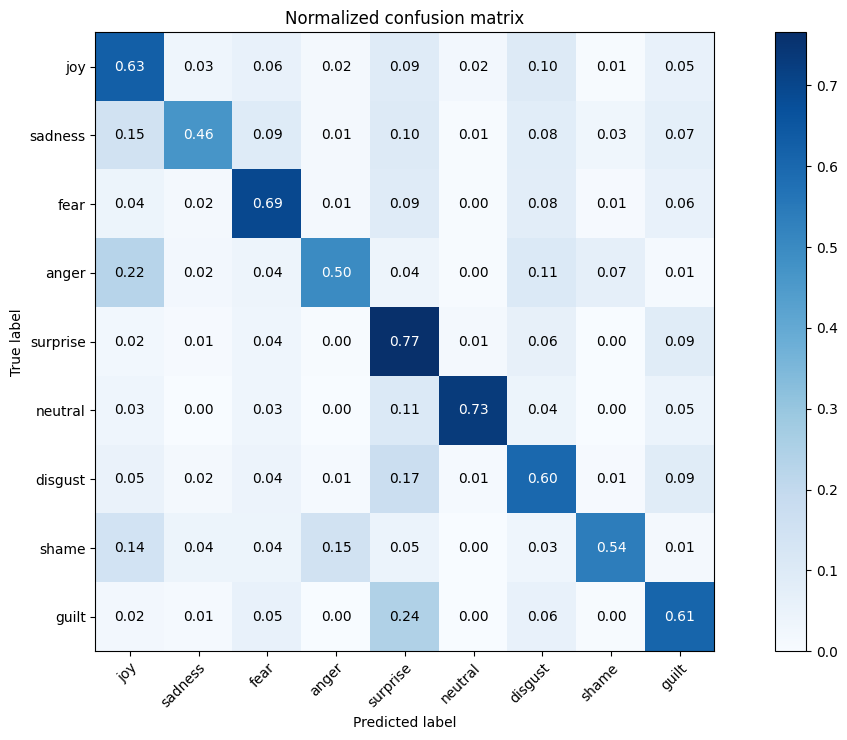

In [ ]:
print("\nF1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))

# Plot normalized confusion matrix
plot_confusion_matrix(data_test.Emotion, predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

In [ ]:
print('Message: {}\nPredicted: {}'.format(X_test[4], predictions[4]))

Message: apparently im getting my wisdom teeth out Friday? 
Predicted: surprise


In [ ]:
import time

message = ['delivery was hour late and my pizza was cold!']

seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)

start_time = time.time()
pred = model.predict(padded)

print('Message: ' + str(message))
print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))

1/1 [==============================] - 0s 276ms/step
Message: ['delivery was hour late and my pizza was cold!']
predicted: joy (0.32 seconds)


In [ ]:
# creates a HDF5 file 'my_model.h5'
model.save('models/biLSTM_w2v.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from keras.models import load_model
predictor = load_model('/content/drive/MyDrive/NLP_PROJECT/models/biLSTM_w2v.h5')

In [ ]:
import os
# List contents of the directory
print(os.listdir('/content/drive/MyDrive/NLP_PROJECT/models/'))


['tfidf_svm.sav', 'cnn_w2v.h5', 'biLSTM_w2v.h5']
